In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
%matplotlib inline 

# config
pd.set_option("display.max_colwidth", 200)

In [2]:
# analysis config
use_languages = False
aggregate_sub_questions = True
na_threshold = 0.1
filter_columns = True

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/Users/shuangziguo/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12,49,51,56,91,126,145,163,165,166,167,168,169,171,173,174,176,177,242,244,246,248,252,255,274,290,291,292,294,295,296,332,344,366,374,376,397,414,440,491,620,634,639,642,643,645,710,713,760,769,810,829,929,954,979,1001,1002,1003,1004,1005,1024,1037,1041,1043,1062,1086,1099,1100,1121,1129,1136,1152,1153,1166,1168,1182,1193,1204,1205,1207,1208,1216,1226,1228,1230,1232,1234) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/shuangziguo/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,13,48,50,55,90,125,144,162,163,164,166,168,169,170,171,172,174,176,241,243,245,247,251,254,273,289,291,292,293,295,296,312,313,314,331,343,365,373,375,396,413,439,490,619,623,630,633,638,642,644,669,712,759,768,788,809,828,928,953,978,1000,10

### Read in code book

In [4]:
# get descriptions for columns
desc = pd.read_csv('WiDS_data_dictionary/Codebook-Table 1.csv')

In [5]:
# make dictionary of column name to description to use later on
desc = desc.assign(ColumnName2=desc['Column Name'].apply(lambda x: str(x).replace('_', '.')))
desc = desc.assign(Description=desc.apply(lambda x: str(x['Question']).split(x['ColumnName2'], 1)[-1], axis=1))
desc = desc.assign(Description=desc.Description.apply(lambda x: x[1:] if len(x) > 1 and x[0] == '.' else x))
desc_dict = pd.Series(desc['Description'].values, index=desc['Column Name'].values).to_dict()

In [6]:
# filter out main question category
desc = desc.assign(MainQuestion=desc['Column Name'].apply(lambda x: str(x).split('_')[0]))

### Basic manipulation of train and test dataset

In [7]:
train.shape

(18255, 1235)

In [8]:
test.shape

(27285, 1234)

In [9]:
# sum up non-NaN values per column
num_not_nan_train = train.apply(lambda x: sum(~pd.isnull(x)), axis=0)
num_not_nan_test = test.apply(lambda x: sum(~pd.isnull(x)), axis=0)

In [10]:
# filter out columns with no data
nan_train_columns = list(num_not_nan_train[num_not_nan_train == 0].index)
nan_test_columns = list(num_not_nan_test[num_not_nan_test == 0].index)
train = train.drop(nan_train_columns, axis=1)
test = test.drop(nan_test_columns, axis=1)

In [11]:
# filter for common columns
common_cols = list(set(train.columns).intersection(test.columns))

In [12]:
train = train[common_cols + ['train_id', 'is_female']]
test = test[common_cols + ['test_id']]

### Sum up answers in the same question group

In [13]:
num_sub_questions = desc[['MainQuestion', 'Column Name']].groupby('MainQuestion').count()

In [14]:
mult_sub_questions = num_sub_questions[num_sub_questions['Column Name'] > 1]

In [15]:
mult_sub_questions.sort_values('Column Name', ascending=False).head(5)

,Column Name
MainQuestion,
DL4,25
FF16,24
IFI10,24
IFI11,24
IFI12,24


In [16]:
# aggregate columns with more than 3 sub questions
mult_sub_questions = mult_sub_questions[mult_sub_questions['Column Name'] > 15]

In [17]:
if aggregate_sub_questions:
    for col in mult_sub_questions['Column Name'].index:
        sub_questions = desc.loc[desc['MainQuestion'] == col, 'Column Name']
        # have to write this properly, right now it seems to work on looking for last sub column
        if sub_questions.iloc[-1] in train.columns:
            train[col] = train[sub_questions].sum(axis=1)
            train = train.drop(sub_questions, axis=1)
        if sub_questions.iloc[-1] in test.columns:    
            test[col] = test[sub_questions].sum(axis=1)
            test = test.drop(sub_questions, axis=1)

In [18]:
sub_train = train.dropna(thresh=na_threshold*len(train), axis=1)
sub_train.shape

(18255, 443)

### Transform language columns 

In [19]:
# transform languages in training set, split up multiple languages into separate columns
# lang_cols = ['language_1', 'language_2', 'language_3','language_4']
df1 = sub_train.LN2_RIndLngBEOth.str.split('&', expand=True)
df1.columns = ['language_1', 'language_2']
df2 = sub_train.LN2_WIndLngBEOth.str.split('&', expand=True)
df2.columns = ['language_3','language_4']
ext_train = pd.concat([sub_train, df1, df2], axis=1)

In [20]:
# transform languages for test set
df1 = test.LN2_RIndLngBEOth.str.split('&', expand=True)
df1.columns = ['language_1', 'language_2']
df2 = test.LN2_WIndLngBEOth.str.split('&', expand=True)
df2.columns = ['language_3','language_4']
ext_test = pd.concat([test, df1, df2], axis=1)

In [21]:
if use_languages:
    train_to_use = ext_train
else:
    train_to_use = sub_train
train_variables = train_to_use.drop(['is_female', 'train_id', 'LN2_RIndLngBEOth', 'LN2_WIndLngBEOth'], axis=1)
target = train_to_use['is_female'].values
test_variables = ext_test[train_variables.columns]

### Measure disparity

In [22]:
# negative number means more females picked the answer
def get_disparity(data, value_col, split_col):
    col_hist = data[['train_id', value_col, split_col]].groupby([value_col, split_col]).count()
    col_hist = col_hist.reset_index()
    col_vals = np.unique(col_hist[col])
    # make sure if no woman or man answered question that summary stats shows 0 for that category
    full_indices = pd.DataFrame({col: list(col_vals)*2, 'is_female': [0]*len(col_vals) + [1]*len(col_vals)})
    col_hist = pd.merge(col_hist, full_indices, on=[col, 'is_female'], how='outer')
    col_hist.loc[pd.isnull(col_hist['train_id']), 'train_id'] = 0
    col_hist = col_hist.sort_values(split_col)
    col_hist = col_hist[[value_col, 'train_id']].groupby(value_col).apply(lambda x: int(x['train_id'].iloc[0] - x['train_id'].iloc[1]))
    return col_hist

In [23]:
disparities = pd.DataFrame()
for col in train_variables.columns:
    col_hist = get_disparity(train_to_use, col, 'is_female')
    abs_col_hist = abs(col_hist)
    pct_col_hist = abs_col_hist / sum(~pd.isnull(train_to_use[col])) * 100
    question = desc_dict[col] if col in desc_dict.keys() else col
    answer_string = desc.loc[desc['Column Name'] == col, 'Values']    
    answer_dict = {}
    if len(answer_string) > 0:
        answers = answer_string.iloc[0].split('\n')
        [answer_dict.update({x.split('=')[0]: x.split('=')[1]}) for x in answers if '=' in x]
        answer_desc = [answer_dict[str(int(x))] if str(int(x)) in answer_dict.keys() else np.NaN for x in 
                       list(col_hist.index)]
    else:
        answer_desc = pd.Series([np.NaN]*len(col_hist))
    col_df = pd.DataFrame({'Question': question, 'Answer': col_hist.index, 'AnswerDesc': answer_desc,
                           'Disparity': col_hist.values, 'AbsDisparity': abs_col_hist.values, 
                           'PctDisparity': pct_col_hist.values,'Column': col})
    disparities = disparities.append(col_df)

In [24]:
disp_cols = ['Question', 'AnswerDesc', 'Disparity', 'PctDisparity']
disparities = disparities.sort_values('AbsDisparity', ascending=False)
disparities[disp_cols].iloc[0:15]
# compared to men women are mainly not the main income earner, more frequently they are housewifes at home, 
# have no financial decision power, no mobile phone, do not know how to use a phone, have no driver's license, 
# do not know how to read or write in English, have no official identification, don't know how to use a bank

,Question,AnswerDesc,Disparity,PctDisparity
1,Who is the main income earner in your household?,Somebody else,-6340,34.730211
1,How are you related to the household head?,Spouse,-5893,32.281567
6,"In the past 12 months, were you mainly...?",Housewife or stay-at-home husband doing household chores,-5398,29.569981
0,Who is the main income earner in your household?,Myself,4985,27.307587
1,Who decides on who should have a phone in your household?,My spouse,-4745,27.117385
0,How are you related to the household head?,Myself,4295,23.527801
1,What or who do you depend on the most for financial advice?,Spouse,-3962,21.703643
0,Who decides on who should have a phone in your household?,Myself,3961,22.636873
1,Do you personally have an active/working SIM card?,No/not sure,-3943,21.599562
0,How did you obtain your phone?,I bought it myself,3785,42.423223


In [25]:
# analyse total disparity of all answers by question
disp_by_col = disparities[['Column', 'Question', 'AbsDisparity', 'Disparity', 'PctDisparity']].groupby(['Column', 'Question']).sum()
disp_by_col = disp_by_col.reset_index()

In [26]:
disp_by_col.head(10)

,Column,Question,AbsDisparity,Disparity,PctDisparity
0,AA14,AA14,4449,-1355,24.371405
1,AA15,AA15,3891,-1355,21.314708
2,AA3,Zone,1745,-1355,9.559025
3,AA4,AA4,2665,-1355,14.598740
4,AA5,Town Class,377,-377,6.669025
5,AA6,Village Class,978,-978,7.760673
6,AA7,AA7,4753,-1355,26.036702
7,DG1,DG1,2307,-1355,12.637634
8,DG10b,DG10b,1115,-1113,13.536482
9,DG10c,DG10c,1244,-1238,18.283363


In [27]:
disp_col = disp_by_col.sort_values('AbsDisparity', ascending=False)['Column'].values
# disp_by_col.loc[(disp_by_col.AbsDisparity < 500) &  (disp_by_col.PctDisparity > 5)]
low_disp_col = disp_by_col.loc[(disp_by_col.AbsDisparity < 500) &  (disp_by_col.PctDisparity < 5), 'Column'].values
len(low_disp_col)

32

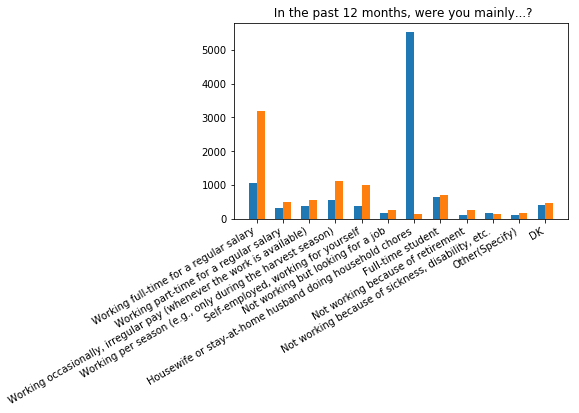

In [28]:
# plot number of women and men picking each answer for a question
col = disp_col[2]
col_hist = sub_train[[col, 'is_female', 'train_id']].groupby([col, 'is_female']).count()
col_hist = col_hist.reset_index()
answers = desc.loc[desc['Column Name'] == col, 'Values'].iloc[0].split('\n')
answer_dict = {}
[answer_dict.update({x.split('=')[0]: x.split('=')[1]}) for x in answers]
col_hist = col_hist.assign(AnswerDesc=col_hist[col].apply(lambda x: answer_dict[str(x)]))
num_answers = len(answer_dict)
ticks = np.arange(num_answers) + 0.5
fig, ax = plt.subplots()
ax.bar(ticks-0.3, col_hist.loc[col_hist['is_female'] == 1, 'train_id'], width=0.3, align='edge')
ax.bar(ticks, col_hist.loc[col_hist['is_female'] == 0, 'train_id'], width=0.3, align='edge')
ax.set_xticks(ticks)
ax.set_xticklabels(col_hist.loc[col_hist['is_female'] == 0, 'AnswerDesc'])
plt.title(desc_dict[col])
fig.autofmt_xdate()

### Filter out columns with low disparity

In [29]:
filt_cols = [x for x in train_variables.columns if x not in low_disp_col]
filt_train = train_variables[filt_cols]
filt_test = ext_test[filt_cols]

### Convert train and test set together

In [30]:
if filter_columns:
    train_test = pd.concat((filt_train, filt_test)) 
else:
    train_test = pd.concat((train_variables, test_variables))

In [31]:
desc = desc.assign(NumVariables=desc.Values.apply(lambda x: str(x).count('\n')+1))
var_to_dummies = desc[desc.NumVariables > 2].iloc[:, 0].values
sub_var_to_dummies = list(set(list(var_to_dummies)).intersection(train_test.columns))

In [32]:
new_train_test = pd.get_dummies(train_test, columns=sub_var_to_dummies).values

In [33]:
new_train = new_train_test[0:len(train)]
new_test = new_train_test[len(train):len(train)+len(test)]

### Fit XGboost model

In [ ]:
# do grid search over max depth and colsample
xgbc = XGBClassifier(objective='binary:logistic', nthread=4, silent=False, n_estimators=2000,
                    subsample=0.7, learning_rate=0.1)
test_params = {'max_depth': [5, 8, 10],
               'colsample_bytree': [0.3, 0.5, 0.7]
              }

gs = GridSearchCV(estimator=xgbc, param_grid=test_params, cv=5)
gs.fit(new_train, target)
gs.best_params_

In [ ]:
xgtrain = xgb.DMatrix(new_train, target)
n_folds = 5
early_stopping = 10
params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.5, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}
bst = xgb.train(params, xgtrain)
bst.cv = xgb.cv(params, xgtrain, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

In [34]:
xgbc = XGBClassifier(objective='binary:logistic', nthread=4, silent=False, learning_rate=0.01,
                     max_depth=10, colsample_bytree=0.7, subsample=0.5, n_estimators=1000)
xgbc.fit(new_train, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.5)

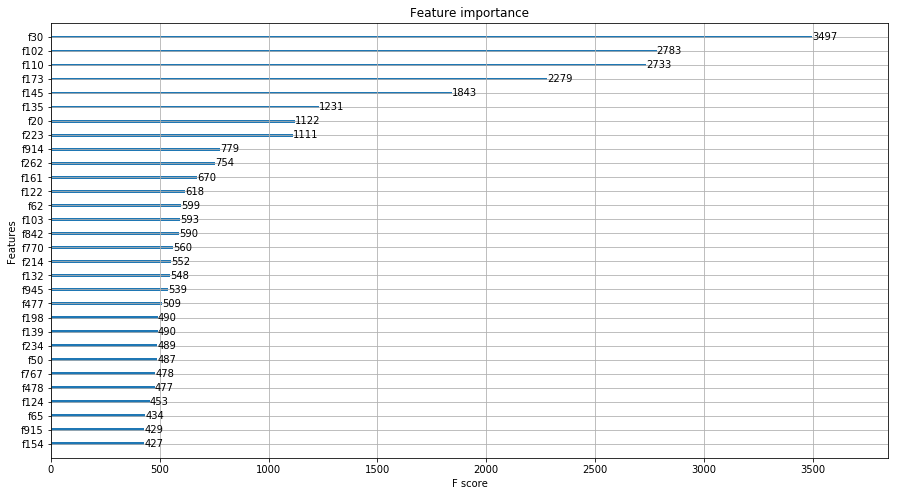

In [182]:
ax = plot_importance(xgbc, max_num_features=30)
ax.figure.set_size_inches(15, 8)

In [71]:
params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.5, 'objective': 'binary:logistic', 
          'seed': 10, 'silent': 0, 'eval_metric':'auc', 'nthread': 4}
bst = xgb.train(params, xgtrain, num_boost_round=850)

### Predict for train set

In [72]:
xg_train2 = xgb.DMatrix(new_train)

In [73]:
predicted_train = bst.predict(xg_train2)
predicted_train

array([0.7519793 , 0.995135  , 0.99397886, ..., 0.01049043, 0.01183765,
       0.99277556], dtype=float32)

In [75]:
100. * sum(abs(predicted_train - target)) / len(target)

7.026137881949916

### Predict for test set

In [77]:
xg_test = xgb.DMatrix(new_test)
predicted_test = bst.predict(xg_test)

In [78]:
predicted_df = pd.DataFrame({'test_id': test['test_id'].values, 'is_female': list(predicted_test)})
predicted_df.to_csv('0.1_10_0.5_agg_filt_submission.csv', index=False)